# Exploratory Analysis

In [166]:
import pandas as pd
import numpy as np
import sklearn as sk
import torch as tc
import matplotlib.pyplot as plt
from scipy.stats import kde
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from light_famd import FAMD
from sklearn import preprocessing
import category_encoders as ce

In [3]:
originaldata = pd.read_csv('../Data/Venta_Consumidor_Producto_UPC_PrevVTA_2018.csv')
originaldata.shape

(1379231, 41)

In [4]:
# Drop columns
dataset = originaldata.drop(columns=['ANO_MES_FACTURA', 'CANAL_VENTA_DESC', 'TEMPORADA_COMERCIAL_DESC', 'MATERIAL_ID', 'ESFUERZO_VENTA_DESC', 'NUMERO_DEUDOR', 'NUMERO_DEUDOR_PAIS_DESC', 'GRUPO_ARTICULO', 'CONCEPTO', 'LINEA',  'PAIS_CONTACTO', 'PAIS_CONTACTO_DESC'])
# Columns I have
dataset.columns

Index(['FACTURA_ID', 'FACTURA_POSICION_ID', 'CUSTOMER_ID',
       'FACTURA_CLASE_DOCUMENTO_ID', 'ANO_FACTURA', 'MES_FACTURA',
       'FECHA_FACTURA', 'IMP_VENTA_NETO_EUR', 'CANAL_VENTA_ID',
       'TEMPORADA_COMERCIAL_ID', 'PRODUCTO_ID', 'TALLA', 'ESFUERZO_VENTA_ID',
       'NUMERO_DEUDOR_PAIS_ID', 'VENTA_DEVOLUCION', 'JERARQUIA_PROD_ID',
       'GRUPO_ARTICULO_PRODUCTO_ID', 'GENERO_PRODUCTO', 'CATEGORIA',
       'TIPOLOGIA', 'COLOR', 'CONSUMER_COLOR', 'CONTACTO_SN', 'EDAD_SN',
       'GENERO_CONTACTO', 'EDAD_COMPRA', 'EDAD_RANGO_COMPRA',
       'CIUDAD_CONTACTO', 'IDIOMA_CONTACTO'],
      dtype='object')

First of all, I am going to see if there are missing data. In the file called Estructura Datos, it says that I used CANAL_VENTA_ID  = 20 because it will be the only one, that's not true, because there are more IDs, by the moment I only use 20 but it would be nice to know which one I should use.

In [5]:
dataset_missing_data = dataset[dataset.CANAL_VENTA_ID == 20]
dataset_missing_data.isnull().sum()

FACTURA_ID                        0
FACTURA_POSICION_ID               0
CUSTOMER_ID                     817
FACTURA_CLASE_DOCUMENTO_ID        0
ANO_FACTURA                       0
MES_FACTURA                       0
FECHA_FACTURA                     0
IMP_VENTA_NETO_EUR              963
CANAL_VENTA_ID                    0
TEMPORADA_COMERCIAL_ID            0
PRODUCTO_ID                       0
TALLA                          6615
ESFUERZO_VENTA_ID               781
NUMERO_DEUDOR_PAIS_ID             0
VENTA_DEVOLUCION                  0
JERARQUIA_PROD_ID                 0
GRUPO_ARTICULO_PRODUCTO_ID        0
GENERO_PRODUCTO                7936
CATEGORIA                      9044
TIPOLOGIA                     12841
COLOR                             0
CONSUMER_COLOR                 7166
CONTACTO_SN                       0
EDAD_SN                           0
GENERO_CONTACTO                 817
EDAD_COMPRA                       0
EDAD_RANGO_COMPRA                 0
CIUDAD_CONTACTO             

- CUSTOMER_ID: I am not interested in it, unless I could create a profile.
- IMP_VENTA_NETO_EUR: Ghost items sold, by the moment I am going to remove these rows, because they are not adding any kind of information and I cannot add NV because I will have problems when I will calculate all the stuff.
- TALLA:
    - I can remove them
    - But I think it would be better to add NV (no informado) as it is used in other columns for the same purpose
- ESFUERZO_VENTA_ID: I don't know what is that
- GENERO_PRODUCTO: the basics are Kids, Women and Men. I can treat nulls as NV (no informado) or consider it as unisex. I prefer NV but I think it is important to keep and don't remove them, they can add value information although there are nulls
- CATEGORIA: I don't think this is an important column, I think I will not use it, by the moment I let them be null
- TIPOLOGIA: I don't think either it is an important column, as before I let them be null
- CONSUMER_COLOR: Same as before, I can use COLOR instead of this
- GENERO_CONTACTO: I am not sure what this is, I can put NV by the moment
- PAIS_CONTACTO: It can be interested to see what products are the most selled in each country and compare them. If one of the others columns refered to the customer are filled, I can extract the country, if not, the best thing I can do is to put NV
- CIUDAD_CONTACTO: Same as before, in this case, for me is not that relevant
- IDIOMA_CONTACTO: Same as before

There aren't NA/nan/Na strings and NV can only be found in the specified columns in the file I said before.

Firstly, I am going to select only the data with CANAL_VENTA_ID equal to 20. Secondly, I am going to remove all the rows where IMP_VENTA_NETO_EUR is equal to null and after I am going to replace all nulls with NV (no informado).

In [6]:
dataset = dataset[(dataset.CANAL_VENTA_ID == 20)]
dataset = dataset[(dataset.IMP_VENTA_NETO_EUR.isnull() == False)]
dataset.fillna("NV", inplace = True)
dataset.isnull().sum()

FACTURA_ID                    0
FACTURA_POSICION_ID           0
CUSTOMER_ID                   0
FACTURA_CLASE_DOCUMENTO_ID    0
ANO_FACTURA                   0
MES_FACTURA                   0
FECHA_FACTURA                 0
IMP_VENTA_NETO_EUR            0
CANAL_VENTA_ID                0
TEMPORADA_COMERCIAL_ID        0
PRODUCTO_ID                   0
TALLA                         0
ESFUERZO_VENTA_ID             0
NUMERO_DEUDOR_PAIS_ID         0
VENTA_DEVOLUCION              0
JERARQUIA_PROD_ID             0
GRUPO_ARTICULO_PRODUCTO_ID    0
GENERO_PRODUCTO               0
CATEGORIA                     0
TIPOLOGIA                     0
COLOR                         0
CONSUMER_COLOR                0
CONTACTO_SN                   0
EDAD_SN                       0
GENERO_CONTACTO               0
EDAD_COMPRA                   0
EDAD_RANGO_COMPRA             0
CIUDAD_CONTACTO               0
IDIOMA_CONTACTO               0
dtype: int64

Outlier detection

Outliers could be find in the following columns (numerical, not definit):
- IMP_VENTA_NETO_EUR
- EDAD_COMPRA

Firstly, I am going to plot the infomation in quartiles and check if I can visualize possible outliers.

FACTURA_ID                      int64
FACTURA_POSICION_ID             int64
CUSTOMER_ID                    object
FACTURA_CLASE_DOCUMENTO_ID     object
ANO_FACTURA                     int64
MES_FACTURA                     int64
FECHA_FACTURA                  object
IMP_VENTA_NETO_EUR            float64
CANAL_VENTA_ID                  int64
TEMPORADA_COMERCIAL_ID          int64
PRODUCTO_ID                    object
TALLA                          object
ESFUERZO_VENTA_ID              object
NUMERO_DEUDOR_PAIS_ID          object
VENTA_DEVOLUCION               object
JERARQUIA_PROD_ID              object
GRUPO_ARTICULO_PRODUCTO_ID    float64
GENERO_PRODUCTO                object
CATEGORIA                      object
TIPOLOGIA                      object
COLOR                          object
CONSUMER_COLOR                 object
CONTACTO_SN                    object
EDAD_SN                        object
GENERO_CONTACTO                object
EDAD_COMPRA                     int64
EDAD_RANGO_C

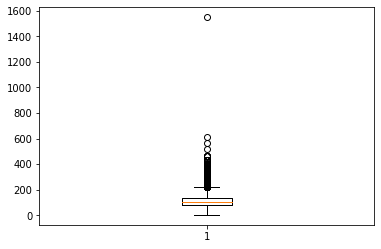

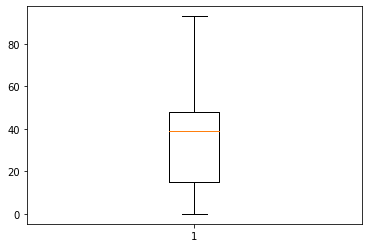

In [32]:
print(dataset.dtypes)
outlierdata = dataset[dataset.FACTURA_CLASE_DOCUMENTO_ID == 'ZTON']
# Univariate outlier detection
plt.boxplot(outlierdata['IMP_VENTA_NETO_EUR'])
plt.show()

plt.boxplot(outlierdata['EDAD_COMPRA'])
plt.show()

For Edad compra we don't have any possible outlier. Otherwise, In imp. venta neto euro, I have found possible outliers, let's analyse them.




In [37]:
print(outlierdata[outlierdata.IMP_VENTA_NETO_EUR >=400][['IMP_VENTA_NETO_EUR', 'PRODUCTO_ID', 'CATEGORIA']].sort_values(by = 'IMP_VENTA_NETO_EUR',ascending=False))

         IMP_VENTA_NETO_EUR    PRODUCTO_ID                 CATEGORIA
135964              1549.59    JB00056-006               Bag - Women
309091               609.50    J300001-003              Men Mid Boot
140910               568.19    J100019-002                  Men Shoe
297395               516.53    ML00005-037                        NV
25078                464.88    J100079-001                  Men Shoe
96533                464.88    J300063-001              Men Mid Boot
149297               464.88    J100079-001                  Men Shoe
174104               464.88    J100091-001                  Men Shoe
202190               464.88    J100080-001                  Men Shoe
166374               433.89    J200104-001  Women Moccasin/Ballerina
55745                433.89    J100062-001                  Men Shoe
1212328              432.40    K300247-001            Men Ankle Boot
1212305              432.40    K300247-001            Men Ankle Boot
1210636              432.40    K30

I don't think I have real outliers, because sounds reasonable I have a bag that costs 1.5k € and shoes over 400€ so I can conclude that my possible outliers are not. But, I haven't seen in the web that prices. As this is 2018 data, I will check 2020 in order to see if these prices are the same. In any case, I can ask to camper's responsable

Now, I am going to analyse the profit by year. As I said before, I use CANAL_VENTA_ID = 20 (Online). Total year (2018) profit is more or less 24 milions of €/$ (?). So now, I will analyse in which months they earn more money. After, I will see what is the percentage got in each month from the total earnings.

Total year profit: 24813778.8€


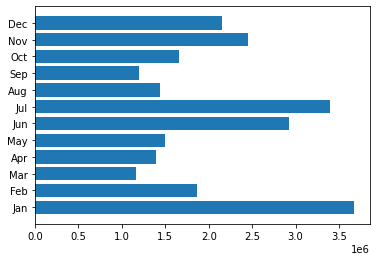

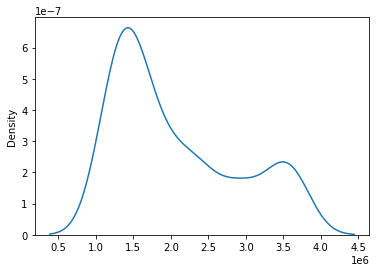

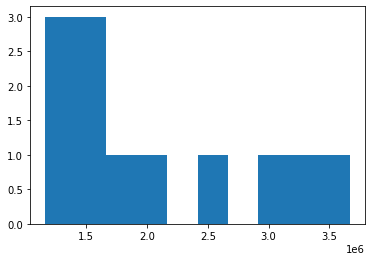

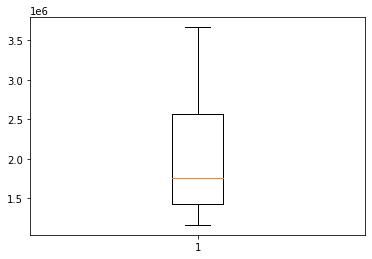

Benefit from each month(%):
Jan: 14.78% from total sales
Feb: 7.53% from total sales
Mar: 4.69% from total sales
Apr: 5.61% from total sales
May: 6.02% from total sales
Jun: 11.78% from total sales
Jul: 13.69% from total sales
Aug: 5.81% from total sales
Sep: 4.84% from total sales
Oct: 6.67% from total sales
Nov: 9.9% from total sales
Dec: 8.68% from total sales


In [8]:
total_year_sold = round(dataset.IMP_VENTA_NETO_EUR.sum(),2)
print('Total year profit: '+str(total_year_sold)+'€')
total_month_sold = round(dataset.groupby(['MES_FACTURA']).IMP_VENTA_NETO_EUR.sum(),2)
total_month_sold = np.array(total_month_sold)
name_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

plt.barh(name_months, total_month_sold)
plt.show()

sns.kdeplot(total_month_sold, bw=0.3) # 0.2
plt.show()

plt.hist(total_month_sold, align= 'mid')
plt.show()

plt.boxplot(total_month_sold)
plt.show()

print('Benefit from each month(%):')
for i in range(0, 12):
    print(name_months[i]+': '+str(round(total_month_sold[i]/(total_year_sold)*100,2))+'% from total sales')

It can be seen in the first graph, the months where the profit is higher are January, June and July. Probably this is because the discounts they do (Sales), we will see it later.
As you can see in the second (density plot) and third (histogram plot) the distribution of the data. If I plot the distribution in quartiles, I can see that the median is closer to the lower quartile, I don't have outliers but the maximum value is large and far from the 3rd quartile.

Finally, Among Jan, June and July, Camper earns the 40% of the total year. It will be interesing to see if this happens in the next years (2019, 2020).

Now, I am going to extract are the bests selling products during the year. I have seen that there are products that are in negative, I think there are two reasons, or these products are sold in other year and this year the customer is returning the product (Weird but possible) or it is possible that the customers bought the product in site and they are returning the products via online.

SHOULD I INVESTIGATE IT? Well, it is possible that the data is wrong.

The top ten products are:

In [9]:
product_sales_year = round(dataset.groupby(['PRODUCTO_ID']).IMP_VENTA_NETO_EUR.sum(), 2)
top_product_sales = product_sales_year.sort_values(ascending = False).head(10)
print(product_sales_year.sort_values(ascending = False).head(10))

PRODUCTO_ID
21595-018      99268.89
20848-017      86711.76
K100243-001    85964.57
17665-014      85405.75
K300005-011    80323.87
K200564-001    74909.57
K200387-004    74226.67
18648-003      73275.18
17408-086      71227.02
K200157-002    71214.81
Name: IMP_VENTA_NETO_EUR, dtype: float64


It is interesting to see which are the bests selling products each month, in this way, we will be able to see if there's any month where the product hits a maximum. I will be focused on the top ten products. It is possible to do this for each product, in this way I would discover if there are any product that during the year has lower sells but when it is in sales, it has a boom. I AM NOT SURE ABOUT DOING THIS FOR EACH PRODUCT, BY THE MOMENT ONLY FOR TOP 10.

In [10]:
product_sales_month = dataset.groupby(['MES_FACTURA','PRODUCTO_ID']).IMP_VENTA_NETO_EUR.sum()
product_sales_month = pd.DataFrame(product_sales_month)
months = []
product_id = []
money = []

for k, v in zip(product_sales_month.index, product_sales_month.IMP_VENTA_NETO_EUR):
    months.append(k[0])
    product_id.append(k[1])
    money.append(v)

In [11]:
product_month_sales = pd.DataFrame({
    'Month': months,
    'Product': product_id,
    'Money': money
})
for i in range(0, len(top_product_sales)):
    val_money = round(product_month_sales[(product_month_sales.Product == top_product_sales.index[i])].Money.max(), 2)
    print(product_month_sales[(product_month_sales.Product == top_product_sales.index[i]) & (product_month_sales.Money.astype(int) == val_money.astype(int))])    

      Month    Product     Money
8333      6  21595-018  13581.26
      Month    Product     Money
9918      7  20848-017  10228.74
       Month      Product     Money
10421      7  K100243-001  11047.11
      Month    Product     Money
9774      7  17665-014  14562.65
       Month      Product     Money
17306     11  K300005-011  45076.14
       Month      Product     Money
10823      7  K200564-001  29961.83
      Month      Product     Money
7551      5  K200387-004  12029.37
    Month    Product    Money
87      1  18648-003  8563.02
    Month    Product     Money
23      1  17408-086  12668.35
       Month      Product     Money
10581      7  K200157-002  39403.88


Looking at the results, 8/10 products are top sellers in jAN/June/July (Sales).

Now, I am going to analyse which season is more successful.

In [12]:
temporada_sales_year = dataset.groupby(['TEMPORADA_COMERCIAL_ID']).IMP_VENTA_NETO_EUR.sum()
for k, v in zip(temporada_sales_year.index, temporada_sales_year):
    if k % 2 == 0:
        print('Temporada Primavera-Verano: '+str(round(v,2))+'€')
    else:
        print('Temporada Otoño-Invierno: '+str(round(v,2))+'€')

Temporada Otoño-Invierno: 5535627.38€
Temporada Primavera-Verano: 11809417.49€
Temporada Otoño-Invierno: 7468733.93€


In 2018, I have three commercial seasons (85, 86, 87).

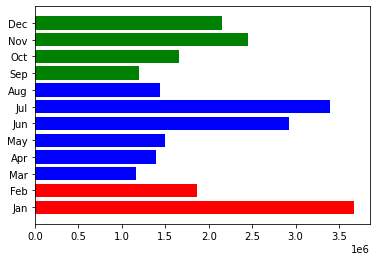

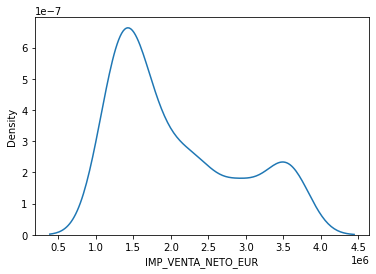

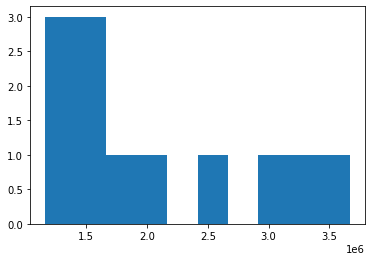

In [13]:
temporada_sales_month = dataset.groupby(['MES_FACTURA', 'TEMPORADA_COMERCIAL_ID']).IMP_VENTA_NETO_EUR.sum()
months = []
sales = []
season = []
for k, v in zip(temporada_sales_month.index, temporada_sales_month):
    if v != 0:
        months.append(k[0])
        season.append(k[1])
        sales.append(v)
season_month_sales = pd.DataFrame({
    'Month': months,
    'Season': season,
    'Money': sales
})
name_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.barh(name_months, season_month_sales.Money, color= season_month_sales['Season'].map({85: 'red', 86: 'blue', 87: 'green'}))
plt.show()

sns.kdeplot(temporada_sales_month, bw=0.3) # 0.2
plt.show()

plt.hist(temporada_sales_month, align= 'mid')
plt.show()

In the first graphic you have the representation of the total sales by month considering each season. (85->red, 86->blue, 87->green).
As it can be seen in the distribution, it looks like a bimodal representation, where it reveals that there are two different types, when it is sales and when it is not. However there are only 3 months of sales, it conditions the density plot because they have a lot of weight (high volume).

Let's analyse the column called TALLA. As I haven't treat yet the missing values, by the moment I am not considering them.

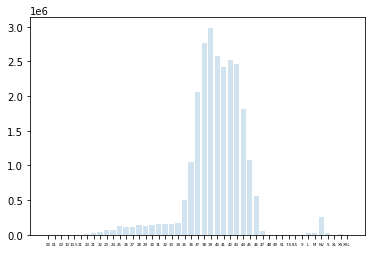

In [14]:
size_sales = dataset.groupby(['TALLA']).IMP_VENTA_NETO_EUR.sum()
size_sales
sales = []
size = []
for k, v in zip(size_sales.index, size_sales):
    if v != 0:
        size.append(k)
        sales.append(v)
size_sales = pd.DataFrame({
    'Size': size,
    'Money': sales
})

plt.bar(size_sales.Size, size_sales.Money, alpha=0.2)
plt.tick_params(axis='x', which='major', labelsize=4)
plt.show()

I can see which size is the most sold for each product. As the size of the dataframe is really big, it would be better to ask if they are interested in any product to filter.

In [15]:
product_size_sales = dataset.groupby(['PRODUCTO_ID', 'TALLA']).IMP_VENTA_NETO_EUR.sum()
product_size_sales
products = []
sizes = []
sales = []

for k, v in zip(product_size_sales.index, product_size_sales):
    if v != 0:
        products.append(k[0])
        sizes.append(k[1])
        sales.append(v)
product_size_sales = pd.DataFrame({
    'Product': products,
    'Size': sizes,
    'Money': sales
})

product_size_sales['max'] = product_size_sales.groupby(['Product']).Money.transform(max)
products = []
sizes = []
sales = []
for _, v in product_size_sales.iterrows():
    if int(v['Money']) == int(v['max']):
      products.append(v['Product'])
      sizes.append(v['Size'])
      sales.append(v['Money'])

size_most_sold = pd.DataFrame({
    'Product': products,
    'Size': sizes,
    'Money': sales
})


Now, I am going to see the distribution of the data grouped by the genre. Same as before, I haven't treated the null variables yet so I am not considering them.

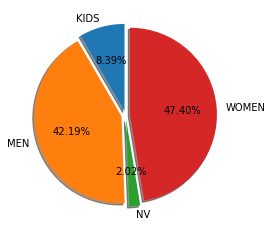

In [16]:
genre_sales_year = dataset.groupby(['GENERO_PRODUCTO']).IMP_VENTA_NETO_EUR.sum()
genre = []
sales = []
for k, v in zip(genre_sales_year.index, genre_sales_year):
    genre.append(k)
    sales.append(v)
genre_sales_year = pd.DataFrame({
    'Genero': genre,
    'Money': sales
})
plt.pie(genre_sales_year.Money, explode=(0.05, 0.05, 0.05, 0.05), labels= genre_sales_year.Genero, autopct='%1.2f%%', shadow= True, startangle= 90)
plt.show()

Looking at the pie chart, women are the most sold, with an almost the 50%, men are the next one with 43%. The genre kids is the worst in terms of sells. The market should be oriented in men and women. Also, they can extract from the data that one open market to exploit is Kids.

TEMPORADA_COMERCIAL_ID  GENERO_PRODUCTO
85                      KIDS                390155.54
                        MEN                2488542.87
                        NV                   69720.67
                        WOMEN              2587208.30
86                      KIDS               1045029.98
                        MEN                4826139.12
                        NV                  267653.91
                        WOMEN              5670594.48
87                      KIDS                647113.16
                        MEN                3155197.49
                        NV                  163216.82
                        WOMEN              3503206.46
Name: IMP_VENTA_NETO_EUR, dtype: float64


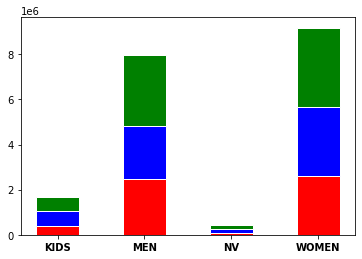

In [17]:
genre_season_sales = dataset.groupby(['TEMPORADA_COMERCIAL_ID', 'GENERO_PRODUCTO']).IMP_VENTA_NETO_EUR.sum()
print(genre_season_sales)
genre = []
seasons = []
sales = []
for k, v in zip(genre_season_sales.index, genre_season_sales):
    seasons.append(k[0])
    genre.append(k[1])
    sales.append(v)
genre_sales_year = pd.DataFrame({
    'Season': seasons,
    'Genero': genre,
    'Money': sales
})
plt.bar([0, 1, 2, 3], genre_sales_year[genre_sales_year.Season == 85].Money, color= 'red', edgecolor='white', width=0.5)
plt.bar([0, 1, 2, 3], genre_sales_year[genre_sales_year.Season == 86].Money, color= 'blue', bottom=genre_sales_year[genre_sales_year.Season == 85].Money, edgecolor='white', width=0.5)
plt.bar([0, 1, 2, 3], genre_sales_year[genre_sales_year.Season == 87].Money, color= 'green', bottom=genre_sales_year[genre_sales_year.Season == 86].Money, edgecolor='white', width=0.5)
plt.xticks([0, 1, 2, 3], ['KIDS', 'MEN', 'NV','WOMEN'], fontweight='bold')
#plt.xlabel("Season")
plt.show()

Checking the results, (season: 85->red, 86->blue, 87->green). In all cases, the best season has been 87 (Otoño-Invierno). Also, the sales from Woman genre are always greater than the others not matter the season. We can see clearly the difference between the KIDS genre and the other two, as I commented previously.

Average customer age: 33.0
  Age_Range       Money
0     19 --    59369.90
1     20-29  1317049.20
2     30-39  4822286.49
3     40-49  6544476.97
4     50-59  3643892.81
5     60-69  1552827.93
6     70 ++   501902.23
7        NS  6371973.27


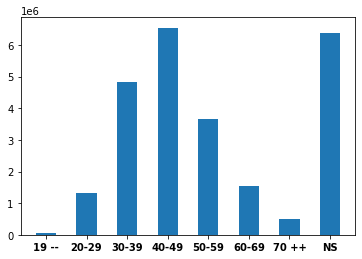

In [18]:
print('Average customer age: '+str(round(dataset.EDAD_COMPRA.mean(), 0)))
age_range_sales = dataset.groupby(['EDAD_RANGO_COMPRA']).IMP_VENTA_NETO_EUR.sum()
money = []
age_range = []
for k, v in zip(age_range_sales.index, age_range_sales):
    money.append(v)
    age_range.append(k)
age_grouped_sales = pd.DataFrame({
    'Age_Range': age_range,
    'Money': money
})
print(age_grouped_sales)
plt.bar([0, 1, 2, 3, 4, 5, 6, 7], age_grouped_sales.Money, width=0.5)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ['19 --','20-29','30-39','40-49','50-59','60-69','70 ++','NS'], fontweight='bold')
plt.show()

As it can be seen in the image above, the graphic of the money earned for each size is following a Gaussian distribution, also there are a lot of non informed size of the product, that's the reason why the bar NS (no informado) has almost the same value of the most sold size (40-49). Without paying attention to the NS', the market should be oriented for people between 30 to 59 years.

Now, I am going to analyse the sales across all the countries where Camper is selling products.

In [19]:
total_sales_country = round(dataset.groupby(['NUMERO_DEUDOR_PAIS_ID']).IMP_VENTA_NETO_EUR.sum(), 2)
print('Top 10 countries: ')
print(total_sales_country.sort_values(ascending = False).head(10))
month_sales_country = round(dataset.groupby(['NUMERO_DEUDOR_PAIS_ID', 'MES_FACTURA']).IMP_VENTA_NETO_EUR.sum(),2)
money = []
month = []
country=[]
for k, v in zip(month_sales_country.index, month_sales_country):
    money.append(v)
    month.append(k[1])
    country.append(k[0])
country_month_sales = pd.DataFrame({
    'Country': country,
    'Month': month,
    'Money': money
})
#Analysee, country+genre+product+age range

Top 10 countries: 
NUMERO_DEUDOR_PAIS_ID
US    4250114.78
GB    3012253.31
ES    2933681.13
DE    2564349.40
IT    1393282.97
FR    1390230.35
AU    1261473.28
JP    1132888.17
TR     804407.56
CA     788905.11
Name: IMP_VENTA_NETO_EUR, dtype: float64


In [20]:
# Analysee, country+genre+product+age range
country_genre_product_age = round(dataset.groupby(['NUMERO_DEUDOR_PAIS_ID', 'GENERO_PRODUCTO', 'PRODUCTO_ID', 'EDAD_RANGO_COMPRA']).IMP_VENTA_NETO_EUR.sum(), 2)
money = []
product = []
country=[]
genre_product = []
age_range = []
for k, v in zip(country_genre_product_age.index, country_genre_product_age):
    money.append(v)
    country.append(k[0])
    genre_product.append(k[1])
    product.append(k[2])
    age_range.append(k[3])

country_genre_product_age = pd.DataFrame({
    'Country': country,
    'Genre_product': genre_product,
    'Product': product,
    'Age_range': age_range,
    'Money': money
})

In [21]:
language_analysis = dataset.groupby(['IDIOMA_CONTACTO']).agg({'FACTURA_ID':'count'}).reset_index().rename(columns= {'FACTURA_ID': 'Count'})
print('Language not informed: '+language_analysis[language_analysis.IDIOMA_CONTACTO == 'NV']['Count'].to_string(index=False))
print('Top 3 most used language:')
print(language_analysis[language_analysis.IDIOMA_CONTACTO != 'NV'].sort_values(by=['Count'] ,ascending = False).head(3))

Language not informed: 1402
Top 3 most used language:
   IDIOMA_CONTACTO   Count
9               EN  169991
7               DE   54760
10              ES   42956


Queda acabar de treure insights de les dades

PCA

In [186]:
# var to cat
# como que lo que quiero es ver las variables que me interesan para el modelo, solo uso las ventas, el modelo tiene que predecir las ventas de un producto y una talla
pcadataset = dataset[dataset.FACTURA_CLASE_DOCUMENTO_ID == 'ZTON']
pcadataset = pcadataset.drop(columns=['FACTURA_ID', 'FACTURA_POSICION_ID', 'CUSTOMER_ID', 'FACTURA_CLASE_DOCUMENTO_ID', 'COLOR', 'ANO_FACTURA', 'CANAL_VENTA_ID', 'VENTA_DEVOLUCION'])
pcadataset['FECHA_FACTURA'] =  pcadataset['FECHA_FACTURA'].str.split('-', expand = True)[2]
pcadataset.PRODUCTO_ID = pcadataset['PRODUCTO_ID'].astype('category')
pcadataset.TALLA = pcadataset['TALLA'].astype('category')
pcadataset.ESFUERZO_VENTA_ID = pcadataset['ESFUERZO_VENTA_ID'].astype('category')
pcadataset.NUMERO_DEUDOR_PAIS_ID = pcadataset['NUMERO_DEUDOR_PAIS_ID'].astype('category')
pcadataset.JERARQUIA_PROD_ID = pcadataset['JERARQUIA_PROD_ID'].astype('category')
pcadataset.GRUPO_ARTICULO_PRODUCTO_ID = pcadataset['GRUPO_ARTICULO_PRODUCTO_ID'].astype('category')
pcadataset.GENERO_PRODUCTO = pcadataset['GENERO_PRODUCTO'].astype('category')
pcadataset.CATEGORIA = pcadataset['CATEGORIA'].astype('category')
pcadataset.TIPOLOGIA = pcadataset['TIPOLOGIA'].astype('category')
pcadataset.CONSUMER_COLOR = pcadataset['CONSUMER_COLOR'].astype('category')
pcadataset.CONTACTO_SN = pcadataset['CONTACTO_SN'].astype('category')
pcadataset.EDAD_SN = pcadataset['EDAD_SN'].astype('category')
pcadataset.GENERO_CONTACTO = pcadataset['GENERO_CONTACTO'].astype('category')
pcadataset.EDAD_RANGO_COMPRA = pcadataset['EDAD_RANGO_COMPRA'].astype('category')
pcadataset.CIUDAD_CONTACTO = pcadataset['CIUDAD_CONTACTO'].astype('category')

In [187]:
# Scale numeric data
scaler = StandardScaler()
scaled = pd.DataFrame(scaler.fit_transform(pcadataset[['IMP_VENTA_NETO_EUR', 'EDAD_COMPRA']]))
pcadataset.index = scaled.index
pcadataset['IMP_VENTA_NETO_EUR'] = scaled[0]
pcadataset['EDAD_COMPRA'] = scaled[1]

In [188]:
#pcadataset.NUMERO_DEUDOR_PAIS_ID.value_counts()

In [189]:
# Encode 2-values labels
pcadataset['CONTACTO_SN'].replace(to_replace= 'S', value = 1, inplace = True)
pcadataset['CONTACTO_SN'].replace(to_replace= 'N', value = 0, inplace = True)
pcadataset['EDAD_SN'].replace(to_replace= 'S', value = 1, inplace = True)
pcadataset['EDAD_SN'].replace(to_replace= 'N', value = 0, inplace = True)
pcadataset["GENERO_PRODUCTO"] = label_encoder.fit_transform(pcadataset[["GENERO_PRODUCTO"]])
pcadataset["GENERO_CONTACTO"] = label_encoder.fit_transform(pcadataset[["GENERO_CONTACTO"]])
encoder = ce.BackwardDifferenceEncoder(cols=['TALLA', 'CATEGORIA', 'NUMERO_DEUDOR_PAIS_ID'])
pcadataset_encoded = encoder.fit_transform(pcadataset)
pcadataset.index = pcadataset_encoded.index
pcadataset_encoded['CONTACTO_SN'] = pcadataset["CONTACTO_SN"]
pcadataset_encoded['GENERO_CONTACTO'] = pcadataset["GENERO_CONTACTO"]
pcadataset_encoded['EDAD_SN'] = pcadataset["EDAD_SN"]

pcadataset_encoded = pcadataset_encoded.drop(columns=['PRODUCTO_ID', 'ESFUERZO_VENTA_ID', 'JERARQUIA_PROD_ID', 'TIPOLOGIA', 'CONSUMER_COLOR', 'EDAD_RANGO_COMPRA', 'CIUDAD_CONTACTO', 'IDIOMA_CONTACTO'])

In [183]:
#pcadataset.CONSUMER_COLOR.value_counts()

In [193]:
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(pcadataset_encoded)

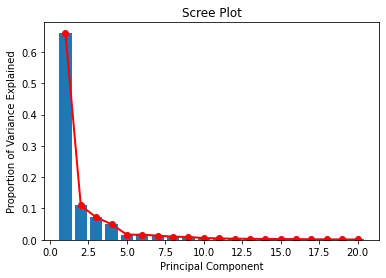

In [194]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.bar(PC_values, pca.explained_variance_ratio_)
plt.show()

In [198]:
print ('Proportion of Variance Explained : ', pca.explained_variance_ratio_)  
out_sum = np.cumsum(pca.explained_variance_ratio_)  
print ('Cumulative Prop. Variance Explained: ', out_sum)
print('Explained variance: ', pca.explained_variance_)
pca.components_

Proportion of Variance Explained :  [0.66115225 0.10953398 0.07170176 0.04988855 0.01640406 0.0162076
 0.01339733 0.01007729 0.00901858 0.00582617 0.00443843 0.00361689
 0.00308662 0.00272299 0.00250976 0.00224337 0.00169779 0.00135735
 0.00123054 0.00101439]
Cumulative Prop. Variance Explained:  [0.66115225 0.77068623 0.84238799 0.89227654 0.9086806  0.9248882
 0.93828552 0.94836281 0.95738139 0.96320755 0.96764599 0.97126288
 0.9743495  0.97707248 0.97958224 0.98182561 0.9835234  0.98488074
 0.98611128 0.98712567]
Explained variance:  [76.11281933 12.60971314  8.25441214  5.74324327  1.88845928  1.86584238
  1.5423199   1.16011196  1.0382322   0.67071676  0.51095866  0.41638183
  0.35533611  0.31347409  0.28892702  0.25826028  0.19545193  0.1562596
  0.14166138  0.11677772]


array([[ 5.55936403e-21, -3.56652803e-02, -9.99301849e-01, ...,
        -7.66427361e-04, -4.67424704e-05, -8.62073357e-04],
       [ 3.84067011e-17,  9.78893126e-01, -3.62534068e-02, ...,
        -5.96136671e-03,  2.11284954e-03, -1.20975406e-02],
       [ 1.33869144e-16, -2.58075252e-02, -2.61360480e-03, ...,
        -1.72929628e-03,  5.80512473e-03, -1.80988863e-02],
       ...,
       [-1.44566000e-17,  2.54965473e-03,  2.47729934e-04, ...,
         1.09669680e-03,  1.85156095e-02, -3.25425541e-04],
       [-8.62053051e-17,  2.56680064e-03, -1.97579405e-04, ...,
         7.43753066e-03, -2.09564823e-02, -6.19111297e-04],
       [-2.09912941e-17, -9.10251432e-03,  6.56979312e-04, ...,
        -3.24421665e-03, -5.12097644e-02,  3.73796276e-03]])

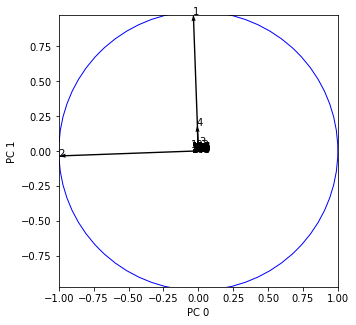

In [199]:
# correlation circle
# Get the PCA components (loadings)
PCs = pca.components_

# Use quiver to generate the basic plot
fig = plt.figure(figsize=(5,5))
plt.quiver(np.zeros(PCs.shape[1]), np.zeros(PCs.shape[1]),
           PCs[0,:], PCs[1,:], 
           angles='xy', scale_units='xy', scale=1)

# Add labels based on feature names (here just numbers)
feature_names = np.arange(PCs.shape[1])
for i,j,z in zip(PCs[1,:]+0.02, PCs[0,:]+0.02, feature_names):
    plt.text(j, i, z, ha='center', va='center')

# Add unit circle
circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
plt.gca().add_artist(circle)

# Ensure correct aspect ratio and axis limits
plt.axis('equal')
plt.xlim([-1.0,1.0])
plt.ylim([-1.0,1.0])

# Label axes
plt.xlabel('PC 0')
plt.ylabel('PC 1')

# Done
plt.show()

In [ ]:
# Linear model